# Определение тарифа

Для анализа предоставлена выборка из двух групп абонентов, пользующихся разными тарифами одной компании.  
  
Тарифы отличаются абонентской платой и лимитом на минуты разговора, СМС и интернет-трафик.  
  
Для каждого абонента известны данные о пользовании тарифом: количество и продолжительность звонков, количество отправленных СМС-сообщений и данные о пользовании интернетом (все вышеперечисленное с указание даты совершения действия). 
  
  Требуется проанализировать данные и сформулировать аналитически- и статистически-обоснованные выводы, которые помогут при принятии решений относительно корректировки рекламного бюджета компании. 

## Импорт и изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mt
import numpy as np
import seaborn as sns

In [2]:
users = pd.read_csv('users.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
calls = pd.read_csv('calls.csv')
tariffs = pd.read_csv('tariffs.csv')

### Таблица _users.csv_

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
ultra_cnt = len(users.query('tariff == "ultra"'))
smart_cnt = len(users.query('tariff == "smart"'))
print(f'Количество абонентов тарифа "Смарт" в выборке: {smart_cnt}')
print(f'Количество абонентов тарифа "Ультра" в выборке: {ultra_cnt}')

Количество абонентов тарифа "Смарт" в выборке: 351
Количество абонентов тарифа "Ультра" в выборке: 149


Наиболее важная особенность: __в выборке более чем в два раза больше пользователей тарифа "Смарт"__ -  более бюджетного варианта. 
Описание пользователей содержит пропуски только в колонке _churn_date_. Возникновение пропусков связано с тем, что на момент сбора данных абонент еще использовал тариф. Удаление пропусков не нужно.  
Перед работой будет необходимо заменить типы данных в колонках _churn_date_, _reg_date_.  
Помимо этого в таблицу будет добавлена колонка _is_active_, содержащая значения True/False, отражающая факт пользования тарифом на момент выгрузки данных.  

### Таблица _messages.csv_.

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


В таблице _messages_ необходимо привести данные в колонке _message_date_ к типу datetime[64].  
Также важно, что колонка _id_ не будет подвергнута каким-либо изменениям за их ненадобностью. 

### Таблица _calls.csv_.

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В таблице _calls.csv_ необходимо заменить тип данных в колонке _call_date_ на datetime[64].  
Данные в колонке _duration_ нужно будет привести к целому количеству минут.  
Помимо этого, важно учитывать, что _0_ в колонке _duration_ соответствует несостоявшемуся звонку. 

### Таблица _internet.csv_.

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [11]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В таблице _internet.csv_ необходимо заменить тип данных в колонке _session_date_ на тип datetime[64].  
Данные в колонке _mb_used_ нужно привести к типу int[64] с округлением в бОльшую сторону.  
Помимо этого, в таблице присутствует колонка _Unnamed: 0_, возникшая, вероятно, при выгрузке данных и содержащая дубли индексов записей. Колонка будет удалена.  
Колонка _id_ менятся не будет

### Таблица _tariffs.csv_.

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные в таблице _tariffs.csv_ в редактировании не нуждаются. 

### Промежуточный вывод. 
В ходе поверхностного знакомства с данными в первом приближении были сформулированы требования по __очистке__ данных, __замене типов__ данных, а также __выявлены особенности и__ явные __ошибки__ в исходных данных. 

## План выполнения проекта
1. Проведение предобработки данных: 
 1. - [x] Удаление лишних столбцов
 2. - [x] Замена типов данных
 3. - [x] Обработка пропусков
 4. - [x] Добавление новых столбцов в случае необходимости
 5. - [x] Промежуточный вывод
2. Проведение расчетов (для каждого пользователя): 
 1. - [x] Количество сделанных звонков и израсходованных минут разговора по месяцам
 2. - [x] Количество отправленных сообщений по месяцам
 3. - [x] Объем израсходованного интернет-трафика по месяцам
 4. - [x] Помесячную выручку с каждого пользователя
 5. - [x] Сбор информации в итоговую сводную таблицу
 5. - [x] Промежуточный вывод
3. Анализ статистик выборки:
 1. - [x] Средние значения
 2. - [x] Дисперсии, стандартные отклонения
 3. - [x] Построение частотных диаграм и кривых распределения плотностей вероятности
 4. - [x] Описание распределений
 5. - [x] Расчет вероятности получения дополнительной прибыли с каждого пользователя
 6. - [x] Промежуточный вывод
4. Проверка гипотез:
 1. - [x] Формулирование нулевых и альтернативных гипотез
 2. - [x] Проведение статистических тестов
 3. - [x] Промежуточный вывод
5. - [x] Общий вывод
  

## Предобработка данных

### Удаление столбцов. 
В таблице _messages.csv_ присутствует колонка, не имеющая смысла и подлежащая удалению.  
Возникновение колонки связано, вероятнее всего, с ошибкой в алгоритме выгрузки данных.

In [14]:
internet = internet.drop(columns=['Unnamed: 0'])

### Замена типов данных. 
Замена будет выполнена в соответствии с ранее сделанными выводами.  
##### Таблица _users.csv_. 
1. Введение формата _datetime64_
2. Добавление колонки _is_active_, содержашей информацию о статусе пользования тарифом

In [15]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['is_active'] = users['churn_date'].isna()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   is_active   500 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(4)
memory usage: 31.9+ KB


##### Таблица _messages.csv_.
1. Введение формата _datetime64_

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


##### Таблица _calls.csv_. 
1. Введение формата _datetime64_
2. Округление данных о продолжительности звонка в бОльшую сторону и приведение к типу _int64_ 

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration']).astype('int64')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


##### Таблица _internet.csv_.
1. Введение формата _datetime64_
2. Округление объема интернет-трафика в бОльшую сторону и приведение к типу _int64_

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int64')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


### Нулевые значения продолжительности звонков и объема использованного трафика. 

#### Таблица _calls.csv_.
__Ключевой параметр, исследуемый в проекте - экономическая эффективность тарифов.__  
Согласно политике ценообразования, за звонок, продолжительностью в 0 секунд, абонент не платит, помимо этого, такие звонки не расходуют ресурс минут тарифа.  
Следовательно, при исследовании прибыльности тарифа, __случаи с нулевой продолжительностью звонка рассматривать нельзя.__ С точки зрения статистики, сохранение записей о звонках с нулевой продолжительностью приведет к __смещению статистик выборки__ в меньшую сторону.  
  
_Примечание_: было проведено сравнение результатов дальнейшего исследования для датасетов с сохраненными нулевыми значениями и без них. Разница в полученных значениях не превысила сотой процента для каждого из показателей. Вероятнее всего, это связано с тем, что при расчетах данные группируются по месяцам и влияение нулевых значений практически полностью нивелируется. 

In [19]:
calls_len_before = len(calls)
calls = calls.query('duration != 0').reset_index(drop=True)
calls_len_after = len(calls)
calls_len_reduce = round(100 * (calls_len_before - calls_len_after) / calls_len_before, 2)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  int64         
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


In [20]:
internet_len_before = len(internet)
internet = internet.query('mb_used != 0').reset_index(drop=True)
internet_len_after = len(internet)
internet_len_reduce = round(100 * (internet_len_before - internet_len_after) / internet_len_before, 2)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  int64         
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.0+ MB


In [21]:
print(f'Сокращение датасета calls составило {calls_len_reduce}%')
print(f'Сокращение датасета internet составило {internet_len_reduce}%')

Сокращение датасета calls составило 19.55%
Сокращение датасета internet составило 13.12%


#### Таблица _users.csv_. 
Данная таблица единственная из всего набора содержит пропуски.  
Однако, согласно техническому заданию, пропуски возникли в результате особенностей алгоритма выгрузки данных и в расчете (на данном этапе) ни на что не влияют.  
В случае возникновения необходимости, пропуски будут удалены в дальнейшем. 

### Добавление новых столбцов. 

Во все таблицы, содержащие данные типа _datetime_ будут добавлены колонки _month_num_ и _month_name_, отвечающие за номер месяца и его название соответственно. 

In [22]:
users['month_num'] = users['reg_date'].dt.month
users['month_name'] = users['reg_date'].dt.month_name()

messages['month_num'] = messages['message_date'].dt.month
messages['month_name'] = messages['message_date'].dt.month_name()

calls['month_num'] = calls['call_date'].dt.month
calls['month_name'] = calls['call_date'].dt.month_name()

internet['month_num'] = internet['session_date'].dt.month
internet['month_name'] = internet['session_date'].dt.month_name()

### Промежуточный вывод. 
В ходе предобработки данных: 
1. Была произведена замена типов (введены типы datetime64, int64) 
2. Количества звонков и израсходованного интернет-трафика были перерассчитаны с учетом политики ценообразования компании
3. Была удалена лишняя колонка в таблице _internet.csv_
4. В имеющиеся таблицы с информацией о датах были добавлены колонки, отвечающие за номер месяца и его название. 

## Расчеты. 

Расчеты будут проведены в следующем порядке: 
1. Данные по минутам, сообщениям и трафику будут сгруппированы по пользователям и месяцам
2. Для каждой составляющей выручки будут рассчитаны количества и израсходованный объем
3. Данные будут объеденены в общую сводную таблицу
4. В полученную таблицу для каждого пользователя и месяца будут добавлены значения месячной выручки

### Минуты разговора. 

In [23]:
calls_pivot = (calls.pivot_table(index=['user_id', 'month_num'], 
                                 values=['id', 'duration'], 
                                 aggfunc={'id': 'count', 
                                         'duration': 'sum'})
                    .rename(columns={'duration': 'minutes_cnt',
                                    'id': 'call_cnt'}))
calls_pivot

minutes_cnt  call_cnt
user_id month_num                       
1000    5                  159        17
        6                  172        28
        7                  340        41
        8                  408        42
        9                  466        46
...                        ...       ...
1498    10                 247        30
1499    9                   70         8
        10                 449        44
        11                 612        62
        12                 492        56

[3168 rows x 2 columns]

###### Количество пользователей, расходовавших минуты

In [24]:
len(calls_pivot.reset_index()['user_id'].unique())

492

### Объем интернет-трафика. 

In [25]:
internet_pivot = (internet.pivot_table(index=['user_id', 'month_num'], 
                                       values=['mb_used', 'id'], 
                                       aggfunc={'mb_used': 'sum', 
                                                'id': 'count'})
                          .rename(columns={'id': 'session_cnt', 
                                           'mb_used': 'mb_cnt'}))
internet_pivot

session_cnt  mb_cnt
user_id month_num                     
1000    5                    4    2256
        6                   44   23257
        7                   28   14016
        8                   27   14070
        9                   25   14581
...                        ...     ...
1498    10                  49   20604
1499    9                    4    1848
        10                  43   17809
        11                  39   17984
        12                  40   13077

[3201 rows x 2 columns]

###### Количество абонентов, пользовавшихся интернетом

In [26]:
len(internet_pivot.reset_index()['user_id'].unique())

497

### СМС-сообщения

In [27]:
messages_pivot = (messages.pivot_table(index=['user_id', 'month_num'], 
                                       values=['id'], 
                                       aggfunc={'id': 'count'})
                          .rename(columns={'id': 'msg_cnt'}))
messages_pivot

msg_cnt
user_id month_num         
1000    5               22
        6               60
        7               75
        8               81
        9               57
...                    ...
1498    10              42
1499    9               11
        10              48
        11              59
        12              66

[2717 rows x 1 columns]

###### Количество абонентов, отправлявших СМС-сообщения

In [28]:
len(messages_pivot.reset_index()['user_id'].unique())

426

### Общая таблица

In [29]:
total_pivot = (calls_pivot.merge(messages_pivot, 
                                 on=['user_id', 'month_num'], 
                                 how='outer') 
                          .merge(internet_pivot, 
                                 on=['user_id', 'month_num'], 
                                 how='outer')
                          .reset_index()
                          .merge(users[['user_id', 'tariff']], 
                                 on='user_id',
                                 how='left')
                          .fillna(0))
print('Количество абонентов, пользовавшихся услугами связи:', len(total_pivot.reset_index()['user_id'].unique()))
total_pivot['gb_cnt'] = np.round(total_pivot['mb_cnt'] / 1024, 2)

Количество абонентов, пользовавшихся услугами связи: 498


После проведения операций, описанных выше, в итоговую таблицу не попали __2 пользователя__, которые, по всей видимости, __не использовали услуги связи__ ни по одному из направлений. 

In [30]:
def total_net_worth(row):
    """
    Функция расчитывает итоговую прибыль для каждого месяца с учетом превышения тарифа (если таковой имеется). 
    
    row: строка датасета total_pivot
    tariff: тариф рассматриваемого пользователя
    total_net_worth: итоговая общая прибыль
    minutes_over_limit: превышение лимита по минутам
    mb_over_limit: превышение лимита по интернет-трафику
    msg_over_limit: превышение лимита по СМС-сообщениям
    tariffs: таблица с данными о тарифах
    
    return: итоговое значение выручки для данного месяца
    """
    #тариф пользователя
    tariff = row['tariff']
    #начальное значение выручки, равное абонентской плате за пользование тарифом
    total_net_worth = tariffs[tariffs['tariff_name'] == tariff]['rub_monthly_fee']
    
    #превышения лимитов
    minutes_over_limit = row['minutes_cnt'] - tariffs[tariffs['tariff_name'] == tariff]['minutes_included']
    mb_over_limit = row['mb_cnt'] - tariffs[tariffs['tariff_name'] == tariff]['mb_per_month_included']
    msg_over_limit = row['msg_cnt'] - tariffs[tariffs['tariff_name'] == tariff]['rub_per_message']
    
    #расчет общей выручки с учетом превышения лимитов, если таковые имеются
    if int(minutes_over_limit) > 0:
        total_net_worth += minutes_over_limit * tariffs[tariffs['tariff_name'] == tariff]['rub_per_minute']
    
    if int(mb_over_limit) > 0:
        total_net_worth += np.ceil(mb_over_limit / 1024) * tariffs[tariffs['tariff_name'] == tariff]['rub_per_gb']
    
    if int(msg_over_limit) > 0:
        total_net_worth += msg_over_limit * tariffs[tariffs['tariff_name'] == tariff]['rub_per_message']
    
    return int(total_net_worth)


total_pivot['total_net_worth'] = total_pivot.apply(total_net_worth, axis=1)
total_pivot

,user_id,month_num,minutes_cnt,call_cnt,msg_cnt,session_cnt,mb_cnt,tariff,gb_cnt,total_net_worth
0,1000,5,159.0,17.0,22.0,4.0,2256.0,ultra,2.20,1971
1,1000,6,172.0,28.0,60.0,44.0,23257.0,ultra,22.71,2009
2,1000,7,340.0,41.0,75.0,28.0,14016.0,ultra,13.69,2024
3,1000,8,408.0,42.0,81.0,27.0,14070.0,ultra,13.74,2030
4,1000,9,466.0,46.0,57.0,25.0,14581.0,ultra,14.24,2006
...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,52.0,19588.0,smart,19.13,1604
3210,1489,11,0.0,0.0,20.0,45.0,17516.0,smart,17.11,1201
3211,1489,12,0.0,0.0,35.0,43.0,17341.0,smart,16.93,1046
3212,1240,2,0.0,0.0,0.0,3.0,961.0,ultra,0.94,1950


In [31]:
print('Количество пропусков в итоговом датасете:', total_pivot.isna().sum(), sep='\n')

Количество пропусков в итоговом датасете:
user_id            0
month_num          0
minutes_cnt        0
call_cnt           0
msg_cnt            0
session_cnt        0
mb_cnt             0
tariff             0
gb_cnt             0
total_net_worth    0
dtype: int64


### Промежуточный вывод. 
После проведения группировки, слияния и расчетов была получена таблица `pivot_table`, содержащая следующие колонки: 
* `user_id` - ID пользователя
* `month_num` - номер месяца, для которого предоставлены данные
* `minutes_cnt` - количество минут
* `call_cnt` - количество совершенных звонков
* `msg_cnt` - количество отправленных сообщений
* `session_cnt` - количество заходов в интернет
* `mb_cnt` - объем израсходованного трафика
* `tariff` - название тарифа
* `gb_cnt` - объем израсходованного трафика в гигабайтах
* `total_net_worth` - итоговое значение выручки для текушего месяца
  
Помимо этого было установлено, что в выборке присутствуют 2 пользователя, не пользовавшиеся услугами связи. 

## Расчет статистик выборки. 

In [46]:
total_pivot

,user_id,month_num,minutes_cnt,call_cnt,msg_cnt,session_cnt,mb_cnt,tariff,gb_cnt,total_net_worth
0,1000,5,159.0,17.0,22.0,4.0,2256.0,ultra,2.20,1971
1,1000,6,172.0,28.0,60.0,44.0,23257.0,ultra,22.71,2009
2,1000,7,340.0,41.0,75.0,28.0,14016.0,ultra,13.69,2024
3,1000,8,408.0,42.0,81.0,27.0,14070.0,ultra,13.74,2030
4,1000,9,466.0,46.0,57.0,25.0,14581.0,ultra,14.24,2006
...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,52.0,19588.0,smart,19.13,1604
3210,1489,11,0.0,0.0,20.0,45.0,17516.0,smart,17.11,1201
3211,1489,12,0.0,0.0,35.0,43.0,17341.0,smart,16.93,1046
3212,1240,2,0.0,0.0,0.0,3.0,961.0,ultra,0.94,1950


In [47]:
mean_values = (total_pivot.pivot_table(index='tariff', values=['minutes_cnt', 'mb_cnt', 'msg_cnt', 
                                                               'total_net_worth', 'gb_cnt'])
                         .reset_index()
                         .rename(columns={'minutes_cnt': 'minutes_cnt_mean',
                                          'mb_cnt': 'mb_cnt_mean',
                                          'gb_cnt': 'gb_cnt_mean',
                                          'msg_cnt': 'msg_cnt_mean', 
                                          'total_net_worth': 'total_net_worth_mean'}))
mean_values['minutes_cnt_mean'] = round(mean_values['minutes_cnt_mean'], 1)
mean_values['msg_cnt_mean'] = round(mean_values['msg_cnt_mean'], 1)
print('Таблица средних значений: ')
mean_values

Таблица средних значений: 


,tariff,gb_cnt_mean,mb_cnt_mean,minutes_cnt_mean,msg_cnt_mean,total_net_worth_mean
0,smart,15.848865,16229.188425,417.9,33.4,1369.744280
1,ultra,19.030041,19486.901523,526.6,49.4,2119.622335


Согласно полученным средним значениям, __абоненты тарифа "Ультра" в среднем используют услуги связи более активно__: они обходят абонентов "Смарта" по использованию всех источников трафика.  
Помимо этого, __абонент тарифа "Ультра" в среднем приносит компании больше прибыли__.  
  
Однако, __абоненты тарифа "Смарт" в среднем переплачивают за исчерпание лимита больше, чем составляет их абонентская плата__ (642 рубля переплат в дополнение к 500 рублям абонентской платы). 

In [48]:
tp_gb = (total_pivot.groupby(by='tariff')[['minutes_cnt', 'gb_cnt', 'msg_cnt']]
                    .agg([np.var, np.std,])
                    .reset_index())
print('Таблица дисперсий и стандартных отклонений:')
tp_gb

Таблица дисперсий и стандартных отклонений:


tariff    minutes_cnt                 gb_cnt                msg_cnt  \
                    var         std        var       std          var   
0  smart   36219.315784  190.313730  32.945063  5.739779   796.812958   
1  ultra  100873.633397  317.606098  97.211828  9.859606  2285.266143   

              
         std  
0  28.227876  
1  47.804457

Согласно полученным значениям стандартных отклонений, распределения показателей шире у абонентов тарифа "Ультра". Иными словами, характеристики абонентов "Ультры" варьируются в более широком диапазоне относительно тех же характеристик абонентов тарифа "Смарт". 

## Построение и анализ распределений.  
Анализ распределения месячного использования минут, сообщений, интернет-трафика и месячной выручки для пользователей обоих тарифов.  
Распределение будет представлено частотной гистограммой и плотностным распределением. 

### Выручка. 

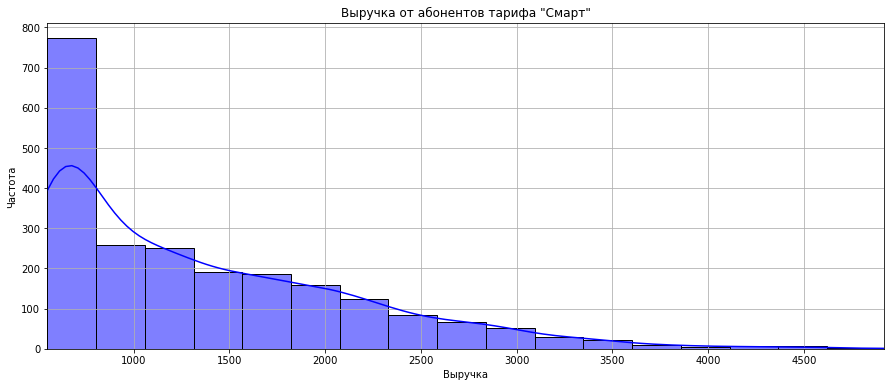

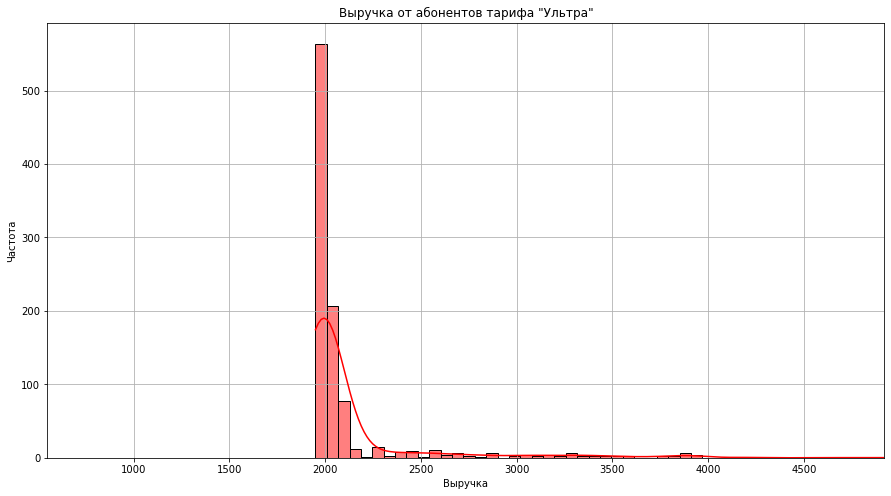

In [49]:
plt.figure(figsize=(15, 6))
plt.grid()
plt.title('Выручка от абонентов тарифа "Смарт"')
plt.ylabel('Частота')
plt.xlabel('Выручка')
plt.xlim(total_pivot.query('tariff == "smart"')['total_net_worth'].min(), total_pivot.query('tariff == "ultra"')['total_net_worth'].max())
try: 
    sns.histplot(data=total_pivot.query('tariff == "smart"'), x='total_net_worth', kde=True, bins=25, color='blue')
except:
    total_pivot.query('tariff == "smart"')['total_net_worth'].plot(kind='hist', bins=25, grid=True)
plt.show()

plt.figure(figsize=(15, 8))
plt.grid()
plt.title('Выручка от абонентов тарифа "Ультра"')
plt.ylabel('Частота')
plt.xlabel('Выручка')
plt.xlim(total_pivot.query('tariff == "smart"')['total_net_worth'].min(), total_pivot.query('tariff == "ultra"')['total_net_worth'].max())
try: 
    sns.histplot(data=total_pivot.query('tariff == "ultra"'), x='total_net_worth', kde=True, bins=50, color='red')
except:
    total_pivot.query('tariff == "ultra"')['total_net_worth'].plot(kind='hist', bins=50, grid=True)
plt.show()

* Распределение по форме совпадает с нормальным.  
* На графиках распределения показаны на одинаковом интервале от минимальной выручки для тарифа "Смарт" до максимальной выручки для тарифа "Ультра".  
* Налицо смещение большинства значений для тарифа смарт влево
* В выборке присутствуют большое количество абонентов тарифа "Смарт" (15% случаев), приносящие больше выручки, чем большинство абонентов "Ультры". 

### Количество отправленных сообщений

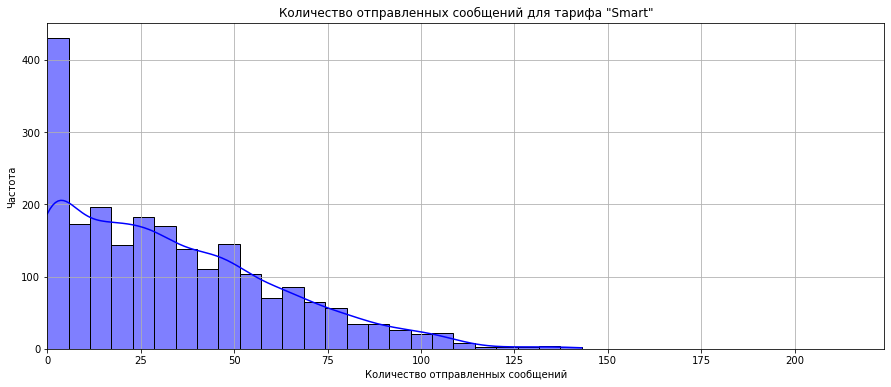

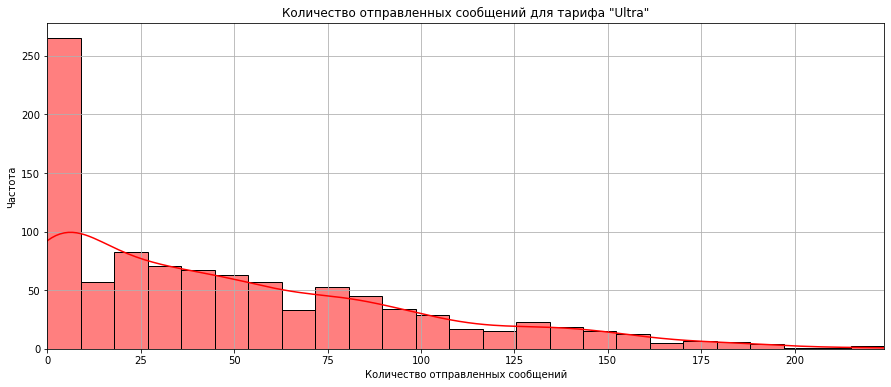

In [50]:
plt.figure(figsize=(15, 6))
plt.title('Количество отправленных сообщений для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['msg_cnt'].max())
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
try: 
    sns.histplot(data=total_pivot.query('tariff == "smart"'), x="msg_cnt", kde=True, bins=25, color='blue')
except:
    total_pivot.query('tariff == "smart"')['msg_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Количество отправленных сообщений для тарифа "Ultra"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['msg_cnt'].max())
plt.xlabel('Количество отправленных сообщений')
plt.ylabel('Частота')
try:
    sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="msg_cnt", kde=True, bins=25, color='red')
except:
    total_pivot.query('tariff == "ultra"')['msg_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

* В обоих случаях наблюдается максимум частоты у нуля, после чего частота монотонно понижается, формируя длинный "хвост" распределения.  
* Вероятнее всего, это связано с крайне низкой востребованностью СМС-сообщений в сравнении с мессенджерами и социальными сетями.  
* Налицо смещенность распределения для тарифа "Смарт" в левую сторону относительно распределения для "Ультры". 

### Количество минут.

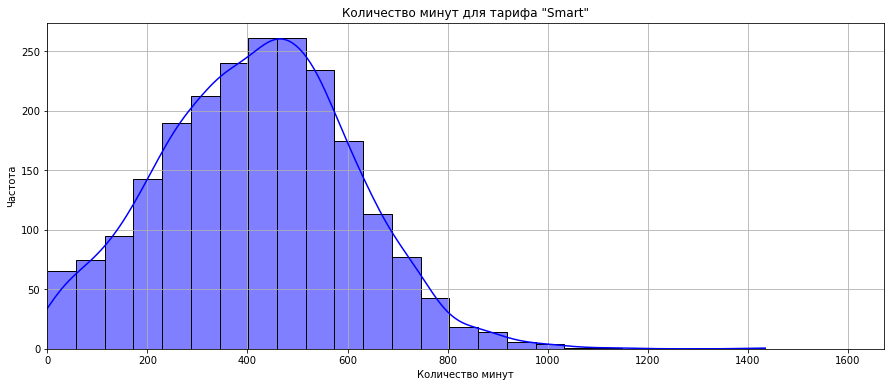

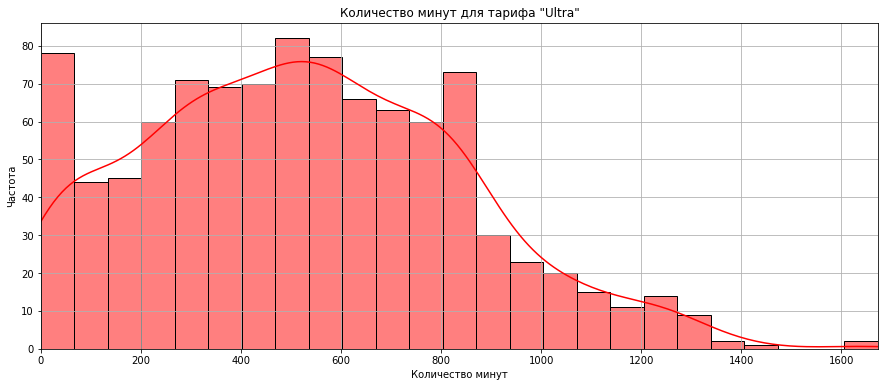

In [51]:
plt.figure(figsize=(15, 6))
plt.title('Количество минут для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['minutes_cnt'].max())
plt.xlabel('Количество минут')
plt.ylabel('Частота')
try: 
    sns.histplot(data=total_pivot.query('tariff == "smart"'), x="minutes_cnt", kde=True, bins=25, color='blue')
except:
    total_pivot.query('tariff == "smart"')['minutes_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Количество минут для тарифа "Ultra"')
plt.grid()
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.xlim(0, total_pivot.query('tariff == "ultra"')['minutes_cnt'].max())
try:
    sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="minutes_cnt", kde=True, bins=25, color='red')
except:
    total_pivot.query('tariff == "ultra"')['minutes_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

* Распределение используемых минут в обоих случаях имеет форму нормального распределения. 
* Как и утверждалось ранее, размах распределения у тарифа "Ультра" больше, а распределение для тарифа "Смарт" смещено влево. 

### Объем интернет-трафика. 

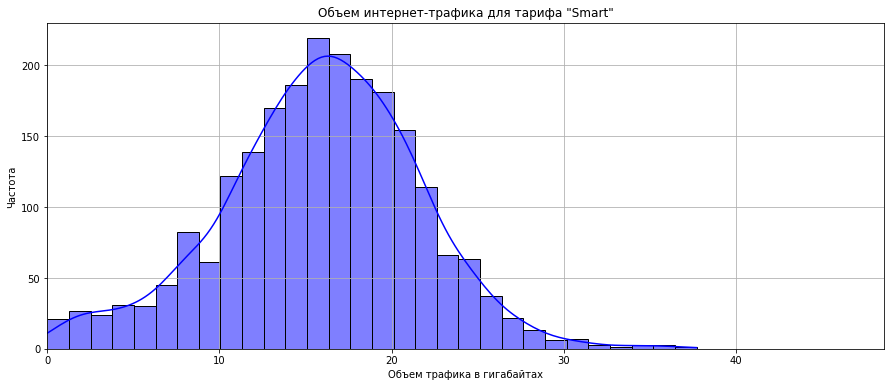

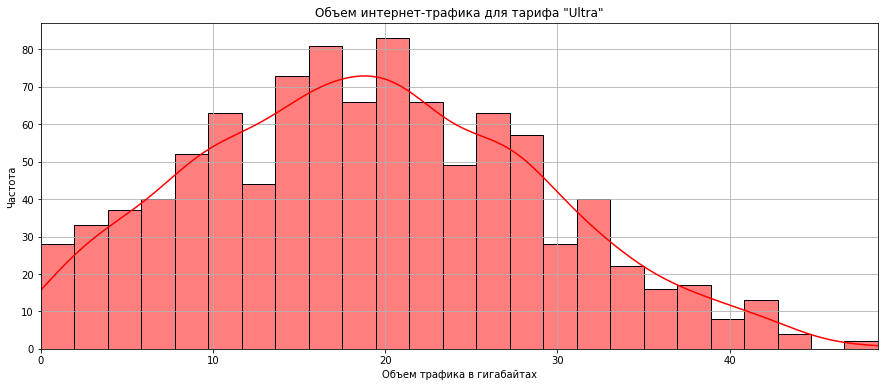

In [52]:
plt.figure(figsize=(15, 6))
plt.title('Объем интернет-трафика для тарифа "Smart"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['gb_cnt'].max())
plt.xlabel('Объем трафика в гигабайтах')
plt.ylabel('Частота')
try: 
    sns.histplot(data=total_pivot.query('tariff == "smart"'), x="gb_cnt", kde=True, bins=30, color='blue')
except:
    total_pivot.query('tariff == "smart"')['gb_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

plt.figure(figsize=(15, 6))
plt.title('Объем интернет-трафика для тарифа "Ultra"')
plt.grid()
plt.xlim(0, total_pivot.query('tariff == "ultra"')['gb_cnt'].max())
plt.xlabel('Объем трафика в гигабайтах')
plt.ylabel('Частота')
try: 
    sns.histplot(data=total_pivot.query('tariff == "ultra"'), x="gb_cnt", kde=True, bins=25, color='red')
except:
    total_pivot.query('tariff == "ultra"')['gb_cnt'].plot(kind='hist', bins=25, grid=True)
plt.show()

Аналогичные выводы и касательно распределений объема трафика: размах шире; данные для "Ультры" смещены вправо относительно данных для "Смарта". 

### Вероятность превышения тарифа (получение дополнительной прибыли) для каждого из компонент тарифа. 

Расчет вероятности превышения тарифного лимита для минут, сообщений и мегабайт интернет-трафика для обоих тарифов.  
Данные значения отражают вероятность того, что пользователь принесет компании дополнительную прибыль.  
Ключевое допущение: распределения аппроксимированы нормальным распределением. 

In [53]:
# расчет средних для тарифа "Смарт"
smart_msg_mu   = total_pivot.query('tariff == "smart"')['msg_cnt'].mean()
smart_calls_mu = total_pivot.query('tariff == "smart"')['minutes_cnt'].mean()
smart_mb_mu    = total_pivot.query('tariff == "smart"')['mb_cnt'].mean()

#расчет стандартных отклонений для тарифа "Смарт"
smart_msg_sigma   = np.std(total_pivot.query('tariff == "smart"')['msg_cnt'], ddof=1)
smart_calls_sigma = np.std(total_pivot.query('tariff == "smart"')['minutes_cnt'], ddof=1)
smart_mb_sigma    = np.std(total_pivot.query('tariff == "smart"')['mb_cnt'], ddof=1)

#аппроксимация распределений с нормальным для тарифа "Смарт"
smart_msg_distr   = st.norm(smart_msg_mu, smart_msg_sigma)
smart_calls_distr = st.norm(smart_calls_mu, smart_calls_sigma)
smart_mb_distr    = st.norm(smart_mb_mu, smart_mb_sigma)

# расчет средних для тарифа "Ультра"
ultra_msg_mu   = np.std(total_pivot.query('tariff == "ultra"')['msg_cnt'], ddof=1)
ultra_calls_mu = np.std(total_pivot.query('tariff == "ultra"')['minutes_cnt'], ddof=1)
ultra_mb_mu    = np.std(total_pivot.query('tariff == "ultra"')['mb_cnt'], ddof=1)

#расчет стандартных отклонений для тарифа "Ультра"
ultra_msg_sigma   = np.std(total_pivot.query('tariff == "ultra"')['msg_cnt'], ddof=1)
ultra_calls_sigma = np.std(total_pivot.query('tariff == "ultra"')['minutes_cnt'], ddof=1)
ultra_mb_sigma    = np.std(total_pivot.query('tariff == "ultra"')['mb_cnt'], ddof=1)

#аппроксимация распределений с нормальным для тарифа "Ультра"
ultra_msg_distr   = st.norm(ultra_msg_mu, ultra_msg_sigma)
ultra_calls_distr = st.norm(ultra_calls_mu, ultra_calls_sigma)
ultra_mb_distr    = st.norm(ultra_mb_mu, ultra_mb_sigma)

In [54]:
#расчет вероятностей для тарифа "Смарт"
smart_msg_lim   = round(100 * (1 - smart_msg_distr.cdf(50)), 1)
smart_calls_lim = round(100 * (1 - smart_calls_distr.cdf(500)), 1)
smart_mb_lim    = round(100 * (1 - smart_mb_distr.cdf(15 * 1024)), 1)

#расчет вероятностей для тарифа "Ультра"
ultra_msg_lim   = round(100 * (1 - ultra_msg_distr.cdf(1000)), 1)
ultra_calls_lim = round(100 * (1 - ultra_calls_distr.cdf(3000)), 1)
ultra_mb_lim    = round(100 * (1 - ultra_mb_distr.cdf(30 * 1024)), 1)

In [55]:
print('Тариф "Смарт". Вероятности превышения тарифного лимита')
print(f'Сообщения:       {(smart_msg_lim)}%')
print(f'Минуты:          {(smart_calls_lim)}%')
print(f'Интернет-трафик: {(smart_mb_lim)}%')
print()
print('Тариф "Ультра". Вероятности превышения тарифного лимита')
print(f'Сообщения:       {(ultra_msg_lim)}%')
print(f'Минуты:          {(ultra_calls_lim)}%')
print(f'Интернет-трафик: {(ultra_mb_lim)}%')

Тариф "Смарт". Вероятности превышения тарифного лимита
Сообщения:       27.8%
Минуты:          33.3%
Интернет-трафик: 55.9%

Тариф "Ультра". Вероятности превышения тарифного лимита
Сообщения:       0.0%
Минуты:          0.0%
Интернет-трафик: 2.1%


#### Промежуточный вывод.
Если аппроксимировать распределения пунктов тарифного плана нормальным распределением, наиболее выгодным с точки зрения переплат является тариф "Смарт": пользователи приносят значительную дополнительную прибыль по всем пунктам тарифа.  
__Если тариф "Смарт" со стороны оператора содержать дешевле, то выгоднее вложиться в его рекламное продвижение.__

### Промежуточный вывод. 
- Формы распределений соответствуют полученым ранее статистикам. Ключевые особенности: 
1. __Размах распределений__ больше у тарифа "Ультра", причем для всех показателей
2. __Пиковые значения частоты__ у распределений для тарифа "Смарт" выше (иногда почти в 3 раза), что связано с тем, что в начальной выборке пользователей этого тарифа в два раза больше 
3. Для всех показателей распределения для тарифа "Смарт" __смещены влево__, что вызвано меньшим объемом минут, СМС и трафика, доступных за абонентскую плату. 
4. __Форма распределения__ всех показателей, кроме сообщений, __совпадает с нормальным__. У распределения сообщений форма совпадает с формой __распределения Пуассона__ 
5. Тарифы схожи тем, что в обоих случаях распределение для сообщений __резко скошено влево__, что связано с низкой востребованностью СМС-сообщений, как средства связи. В данной выборке пользователи ни одного из тарифов не превышают лимит по сообщениям. 
  
 
 
- На основании статистики по переплатам наиболее выгоден тариф "Смарт" (в случае, если его содержание обходится компании дешевле). 

## Проверка гипотез. 
### Гипотеза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. 

#### Нулевая гипотеза
_Средние выручки от абонентов тарифов "Смарт" и "Ультра" равны._  
#### Альтернативная гипотеза
_Средние выручки от абонетов тарифов "Смарт" и "Ультра" различны._
  
Важно! Ранее при анализе "трат" пользователей было установлено, что по всем аспектам (звонки, СМС, интернет) абоненты разных тарифов отличаются.  
Соответственно, при проведении статистических тестов __дисперсии выборок будем считать разными__.  
__Уровень статистической значимости примем равным 5%__. 

In [56]:
#вычленение исследуемых выборок
smart = total_pivot.reset_index().query('tariff == "smart"')['total_net_worth']
ultra = total_pivot.reset_index().query('tariff == "ultra"')['total_net_worth']

print('Объем выборки для тарифа "Смарт":', len(smart))
print('Объем выборки для тарифа "Ультра":', len(ultra))
print('Соотношение объемов выборок:', round(len(smart) / len(ultra), 1))

Объем выборки для тарифа "Смарт": 2229
Объем выборки для тарифа "Ультра": 985
Соотношение объемов выборок: 2.3


In [57]:
results = st.ttest_ind(smart, ultra, equal_var=False)

alpha = 0.05

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha): 
    print('Нулевая гипотеза опровергнута')
else: 
    print('Не удалось опровергнуть нулевую гипотезу')

p-значение:  9.332582164180644e-229
Нулевая гипотеза опровергнута


#### Промежуточный вывод: 
__средняя выручка пользователей разных тарифов различна__.  
  
Параметры теста: 
1. Уровень статистической значимости: 5%
2. Выборки имеют разные дисперсии
3. Объемы выборок: 
 1. "Смарт": 2174
 2. "Ультра": 940
 3. Соотношение объемов: 2.3

### Гипотеза №2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Нулевая гипотеза
_Средние выручки пользователей из Москвы и других регионов равны_

#### Альтернативная гипотеза
_Средние выручки пользователей из Москвы и других регионов различны_

In [58]:
#вычленение исследуемых выборок
moscow_users = users.query('city == "Москва"')['user_id']
other_cities_users = users.query('city != "Москва"')['user_id']

In [59]:
moscow_users_data = total_pivot.reset_index().query('user_id in @moscow_users')
moscow_users_cnt = len(moscow_users_data['user_id'].unique())
print(f'Количество пользователей из Москвы: {moscow_users_cnt}')

other_cities_users_data = total_pivot.reset_index().query('user_id in @other_cities_users')
other_cities_users_cnt = len(other_cities_users_data['user_id'].unique())
print(f'Количество пользователей из других городов: {other_cities_users_cnt}')
print()
print('Объем выборки с абонентами из Москвы:', len(moscow_users_data))
print('Объем выборки с абонентами из других регионов:', len(other_cities_users_data))
print('Соотношение объемов выборок:', round(len(other_cities_users_data) / len(moscow_users_data), 1))

Количество пользователей из Москвы: 99
Количество пользователей из других городов: 399

Объем выборки с абонентами из Москвы: 611
Объем выборки с абонентами из других регионов: 2603
Соотношение объемов выборок: 4.3


Очевидно, на этапе очистки итоговой таблицы от выбросов (см. пункт 1.5) все 5 удаленных пользователей проживают в регионах. 

In [60]:
results = st.ttest_ind(moscow_users_data['total_net_worth'], other_cities_users_data['total_net_worth'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Нулевая гипотеза опровергнута')
else:
    print('Не удалось опровергнуть нулевую гипотезу')

p-значение: 0.6780982478156512
Не удалось опровергнуть нулевую гипотезу


#### Промежуточный вывод. 
Согласно проведенному t-тесту, __средние выручки от абонентов из Москвы и абонентов из других регионов равны.__
  
  
Параметры теста: 
1. Уровень статистической значимости: 5%
2. Выборки приняты равными по дисперсии
3. Объемы выборок: 
 1. Данные по абонентам из Москвы: 602
 2. Данные по абонентам из других регионов: 2512
 3. Соотношения объемов выборок: 4.2

### Промежуточный вывод.
Результаты статистического тестирования: 
1. __Средняя выручка__ от абонентов тарифа "Смарт" __отличается__ от средней выручки от абонентов тарифа "Ультра"
2. __Средняя выручка__ от абонентов из Москвы __равна__ средней выручке от абонентов из других регионов

## Общий вывод

В ходе выполнения проекта: 
1. __Данные исследованы__ отдельно в рамках исходных таблиц
2. Была проведена __замена типов данных__
3. В таблицы были __добавлены новые колонки__ с преобразованными величинами
4. __Нулевые значеня__ были удалены
5. Были __проведены расчеты__ значений суммарной выручки и выручки от отдельных компонентов тарифа
6. Данные были __собраны в общую__ сводную __таблицу__
7. Общая сводная таблица была __очищена от выбросов__
8. Для очищенной сводной таблицы были проведены __расчеты статистик, построены__ частотные и плотностные __распределения__
9. На основании очищенных данных были __расчитаны вероятности__ того что пользователь принесет дополнительную прибыль за счет превышения тарифа
10. Были __проверены статистические гипотезы__, связанные с прибыльностью абонентов и тарифов.

__При корректировке рекламного бюджета необходимо учесть следующее:__ 
1. Абоненты тарифа "Смарт" переплачивают значительно чаще, чем абоненты тарифа "Ультра"
 - _за сообщения_: 26.3% случаев (против 0% для "Ультры)
 - _за минуты_   : 31.8% случаев (против 0% для "Ультры)
 - _за интернет_ : 56.7% случаев (против 2.1% для "Ультры)
2. Средняя выручка от абонентов тарифа "Смарт" не равна средней выручке от абонентов тарифа "Ультра"
3. Средняя выручка от абонентов из Москвы не отличается от средней выручки от абонентов из регионов